In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import ripser
import TDAvectorizer
from TDAvectorizer import computeNL, computeVAB, computeVPB, computePL, computePS, computeECC, computePES, computePI, DiagToPD

# Test TDAvectorizer package

In this file I am testing all functions from the TDAvectorizer package

## Separate functions

All the vectorization functions are realized as cython functions and are exported from `TDAvec.pyx` file. Let me show you how to use them and compare results with generated by R

Here is a point cloud that we will use:

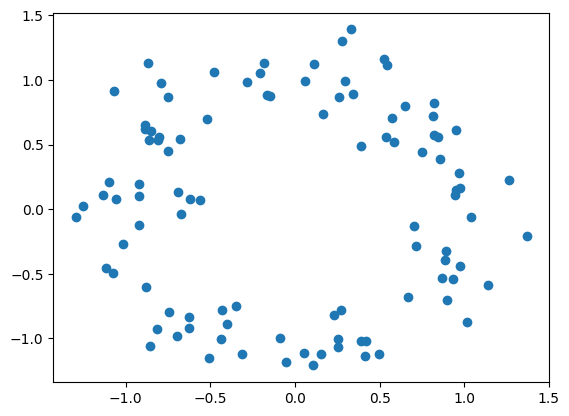

In [2]:
X = np.loadtxt("../R/unitCircle.csv", skiprows=1, delimiter=",")
plt.plot(X[:,0], X[:,1], "o")
plt.show()

I am going to use Ripser to create persistence diagrams.

In [3]:

D = ripser.ripser(X, thresh=2)["dgms"]
D[0][-1, 1] = 2


Let me try computeNL as an example

In [4]:
scaleSeq = np.linspace(0, 2, 11)
print("computeNL:")
for d in [0,1]:
    pyth = computeNL(D, d, scaleSeq)
    R = np.loadtxt("../R/nl_{}.csv".format(d), skiprows=1)
    cond = np.allclose( pyth, R, atol=1e-7)
    print(f"\t dim={d}: {cond}")

computeNL:
	 dim=0: True
	 dim=1: True


As you can see, the results are equal to R. The same agreement holds for other vectorization functions

In [5]:
scaleSeq = np.linspace(0, 2, 11)
print("computePL:")
for d in [0,1]:
    pyth = computePL(D, d, scaleSeq)
    R = np.loadtxt("../R/pl_{}.csv".format(d), skiprows=1)
    cond = np.allclose( pyth, R, atol=1e-7)
    print(f"\t dim={d}: {cond}")

computePL:
	 dim=0: True
	 dim=1: True


In [6]:
scaleSeq = np.linspace(0, 2, 11)
print("computePS:")
for d in [0,1]:
    pyth = computePS(D, d, scaleSeq)
    R = np.loadtxt("../R/ps_{}.csv".format(d), skiprows=1)
    cond = np.allclose( pyth, R, atol=1e-7)
    print(f"\t dim={d}: {cond}")

computePS:
	 dim=0: True
	 dim=1: True


In [7]:
scaleSeq = np.linspace(0, 2, 11)
print("computeVAB:")
for d in [0,1]:
    pyth = computeVAB(D, d, scaleSeq)
    R = np.loadtxt("../R/vab_{}.csv".format(d), skiprows=1)
    cond = np.allclose( pyth, R, atol=1e-7)
    print(f"\t dim={d}: {cond}")

computeVAB:
	 dim=0: True
	 dim=1: True


In [8]:
scaleSeq = np.linspace(0, 2, 11)
print("computeECC:")
for d in [0,1]:
    pyth = computeECC(D, d, scaleSeq)
    R = np.loadtxt("../R/ecc_{}.csv".format(d), skiprows=1)
    cond = np.allclose( pyth, R, atol=1e-7)
    print(f"\t dim={d}: {cond}")

computeECC:
	 dim=0: True
	 dim=1: True


In [9]:
scaleSeq = np.linspace(0, 2, 11)
print("computePES:")
for d in [0,1]:
    pyth = computePES(D, d, scaleSeq)
    R = np.loadtxt("../R/pes_{}.csv".format(d), skiprows=1)
    cond = np.allclose( pyth, R, atol=1e-7)
    print(f"\t dim={d}: {cond}")

computePES:
	 dim=0: True
	 dim=1: True


Here is how computeVPB works:

In [10]:
PD = DiagToPD(D)
ySeqH0 = np.quantile(PD[0][:,1], np.arange(0, 1.1, 0.2))
vpb0 = computeVPB(PD, homDim=0, xSeq = [], ySeq = ySeqH0)
print(np.allclose(
    vpb0, 
    np.loadtxt("../R/vpb_0.csv", skiprows=1)
    , atol=1e-7))


xSeqH1 = np.quantile(PD[1][:,0], np.arange(0, 1.1, 0.2))
ySeqH1 = np.quantile(PD[1][:,1], np.arange(0, 1.1, 0.2))

vpb1 = computeVPB(PD, homDim = 1, xSeq=xSeqH1, ySeq=ySeqH1)
vpb1 = np.transpose(vpb1).reshape( (25,))
print(np.allclose(
    vpb1, 
    np.loadtxt("../R/vpb_1.csv", skiprows=1)
    , atol=1e-7))


True
True


Here is computePI:

In [11]:
resB, resP = 5, 5
#
minPH0, maxPH0 = np.min(PD[0][:,1]), np.max(PD[0][:,1])
ySeqH0 = np.linspace(minPH0, maxPH0, resP+1)
xSeqH0 = np.zeros( resB+1)

minBH1, maxBH1 = np.min(PD[1][:,0]), np.max(PD[1][:,0])
xSeqH1 = np.linspace(minBH1, maxBH1, resB+1)
minPH1, maxPH1 = np.min(PD[1][:,1]), np.max(PD[1][:,1])
ySeqH1 = np.linspace(minPH1, maxPH1, resP+1)

sigma = 0.5*(maxPH0-minPH0)/resP
pi0 = computePI(PD, homDim = 0, xSeq = xSeqH0, ySeq = ySeqH0, sigma = sigma)
pi0_R = np.loadtxt("../R/pi_0.csv", skiprows=1)
print(0, np.allclose(pi0, pi0_R))

sigma = 0.5*(maxPH1-minPH1)/resP
pi1 = computePI(PD, homDim = 1, xSeq = xSeqH1, ySeq = ySeqH1, sigma = sigma)
pi1_R = np.loadtxt("../R/pi_1.csv", skiprows=1)
print(1, np.allclose(pi1, pi1_R))


0 True
1 True


## Class wrapper

As you can see, separate vectorization functions produce exactly the expected results, so they can easily used as they are. It could be a good idea to use a class wrapper to make them more user-friendly and follow usual python ideology. This can be done using the `TDAvectorizer` class.

In [12]:
vect = TDAvectorizer.TDAvectorizer()

Let me first create some points clouds:

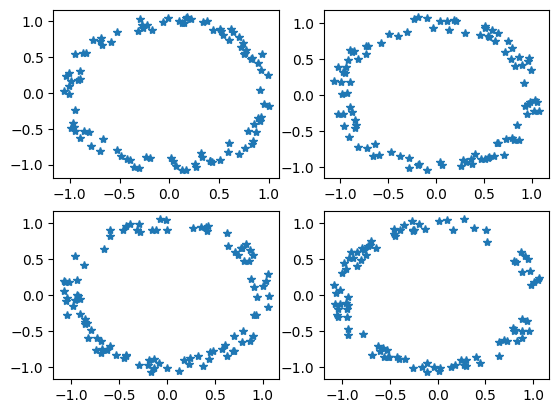

In [16]:

clouds = []
for i in range(4):
    clouds = clouds + [vect.createEllipse()]
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    ax.plot( clouds[i][:,0], clouds[i][:,1], "*")

We can process these clouds using the `fit` method:

In [17]:
    
vect.fit(clouds)

As a result, we get a list of persistence diagrams will be created:

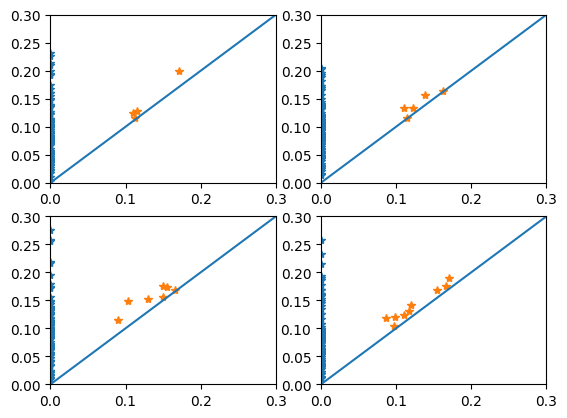

In [23]:
for i in range(4):
    ax = plt.subplot(2, 2, i+1)
    ax.plot( vect.diags[i][0][:,0], vect.diags[i][0][:,1], "*")
    ax.plot( vect.diags[i][1][:,0], vect.diags[i][1][:,1], "*")
    ax.set_ylim(0, 0.3)
    ax.set_xlim(0, 0.3)
    ax.axline( (0,0), slope=1)
plt.ticklabel_format()

Now we can transform these persistence diagrams into vector representation using the `transform` method.

Here, for example, you can see PL vectorization

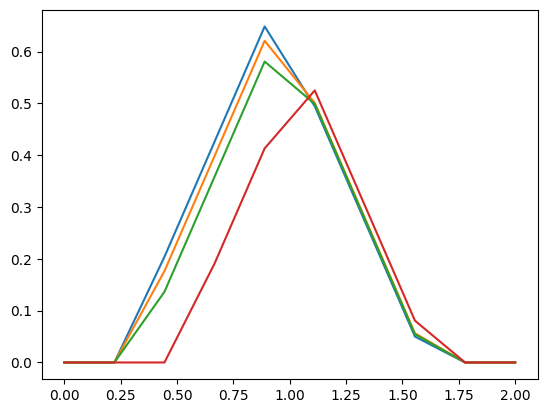

In [27]:
xSeq = np.linspace(0,2,10)
vvv = vect.transform(homDim = 1, output = "PL", xSeq = xSeq)
for v in vvv:
    plt.plot(xSeq, v)

With a simple change of parameters, you can consider the PS vectorization

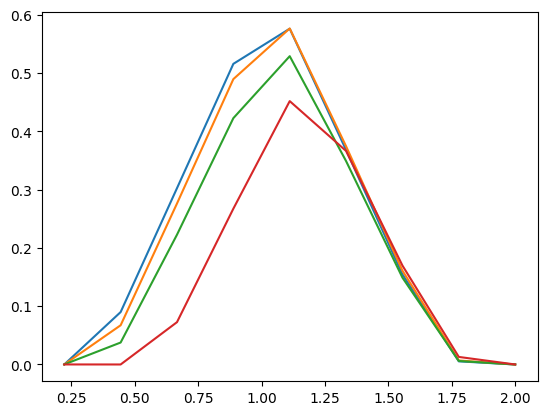

In [29]:
vvv = vect.transform(homDim = 1, output = "PS", xSeq = xSeq)
for v in vvv:
    plt.plot(xSeq[1:], v)

## Regression Example

In [69]:
vvv.shape

(4, 9, 9)

In [35]:
vvv0 = vect.transform(homDim = 1, output = "PS", k=0)
vvv1 = vect.transform(homDim = 1, output = "PS", k=1)
vvv2 = vect.transform(homDim = 1, output = "PS", k=2)

PS
k =  0
PS
k =  1
PS
k =  2


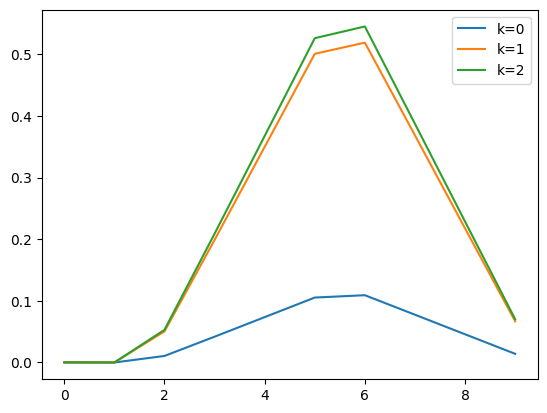

In [37]:
plt.plot(vvv0[0], label = "k=0")
plt.plot(vvv1[0], label = "k=1")
plt.plot(vvv2[0], label = "k=2")
plt.legend()

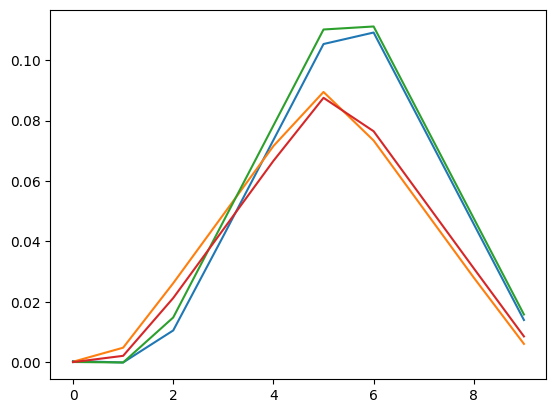

In [30]:
for v in vvv:
    plt.plot(v)

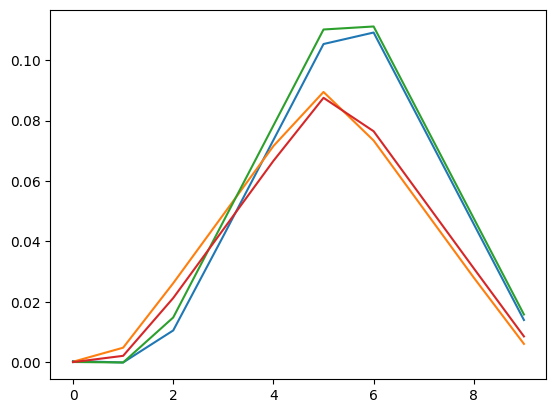

In [ ]:
for v in vvv:
    plt.plot(v)

In [7]:
vab

array([[0.38019654, 0.30433686, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.36996568, 0.84262842, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.60673255],
       [0.37160147, 0.48846091, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.91928861],
       [0.42698142, 0.23899696, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.89231297]])

In [107]:
vect.computeVAB(vect.diags[0], homDim = 1, scaleSeq = vect.params["scale"])

array([0.02263527, 0.54224413, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98358766])

In [98]:

vect.setParams({"output":"PL"})
assert vect.getParams("output") == "PL"

4

In [89]:
vect.findLimits(1)

{'minB': 0.04747302457690239,
 'maxB': 1.643264889717102,
 'minD': 0.049179304391145706,
 'maxD': 0.04747302457690239}

In [67]:
np.array([d[0][:,0] for d in vect.diags]).min()
np.array([d[0][:,0] for d in vect.diags]).max()

0.0

In [62]:
vect.findLimits(0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [54]:
len(vect.diags)

2

In [47]:
vect.diags[0][0][-1]

array([0., 2.])

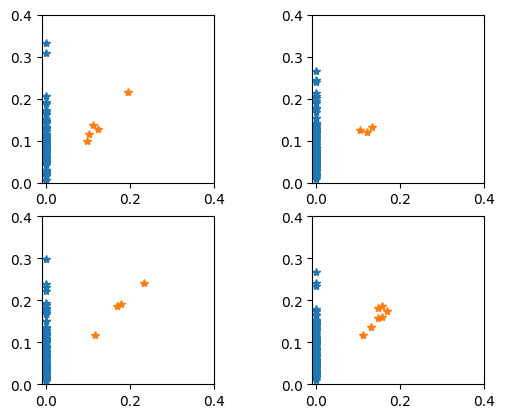

In [38]:
for i in range(len(vect.diags)):
    plt.subplot(2, 2, i+1)
    plt.plot( vect.diags[i][0][:,0], vect.diags[i][0][:,1], "*")
    plt.plot( vect.diags[i][1][:,0], vect.diags[i][1][:,1], "*")
    plt.xlim(-0.01, 0.4)
    plt.ylim(0, 0.4)
    plt.gca().set_aspect('equal', adjustable='box')